# Лабораторная работа № 2

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns

houses_prices = pd.read_csv('../data/houses_prices.csv')
cars_prices = pd.read_csv('../data/cars_prices.csv')
heart_disease_indicators = pd.read_csv('../data/heart_disease_indicators.csv')

## 1. Выбор наборов данных

Были выбраны следующие датасеты:

1. [House Sales Prediction](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction) — данные о продажах домов в King County, США.
2. [Car Price Prediction Challenge](https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge) — данные о ценах на автомобили.
3. [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease) — индикаторы риска сердечных заболеваний.

## 2. Анализ сведений о наборах данных на Kaggle

- House Sales Prediction:

  Проблемная область — недвижимость и прогнозирование цен на жилье. Датасет содержит 21 613 записей о продажах домов в King County (Сиэтл, США) за 2014–2015 гг. Цель — предсказать цену дома на основе характеристик (площадь, год постройки и т.д.). Актуально для риелторов, банков и инвесторов в property market.

- Car Price Prediction Challenge:

  Проблемная область — автомобильный рынок и ценообразование. Датасет с ~7 500 записями о подержанных авто (марка, модель, пробег, год выпуска). Фокус на предсказании цены для дилеров, страховщиков и онлайн-платформ вроде Auto.ru или CarGurus. Включает глобальные бренды (Lexus, Honda и т.д.).

- Personal Key Indicators of Heart Disease:

  Проблемная область — здравоохранение и профилактика сердечно-сосудистых заболеваний. Датасет на основе опроса BRFSS (CDC, США) с ~319 000 записями. Содержит демографические, поведенческие и медицинские индикаторы (курение, BMI, вакцинации). Цель — выявление рисков для public health policy, клиник и фитнес-приложений.

## 3. Анализ содержимого наборов данных

- House Sales Prediction:

    - Объекты наблюдения:

      Отдельные дома (единичные транзакции продаж).

    - Атрибуты:

      21 признак — id (уникальный ID), date (дата продажи), price (целевая цена, USD), bedrooms (спальни), bathrooms (ванные), sqft_living (площадь жилой зоны), sqft_lot (площадь участка), floors (этажи), waterfront (вид на воду: 0/1), view (вид: 0–4), condition (состояние: 1–5), grade (класс: 1–13), sqft_above (площадь над землей), sqft_basement (подвал), yr_built (год постройки), yr_renovated (год ремонта, 0 если нет), zipcode (почтовый индекс), lat/long (координаты), sqft_living15/sqft_lot15 (средние по соседям).

    - Связи между объектами:

      Слабые — через zipcode (географические кластеры), lat/long (пространственные). Нет явных реляционных связей (плоский датасет).

- Car Price Prediction Challenge:

    - Объекты наблюдения:

      Отдельные автомобили (подержанные).

    - Атрибуты:

      17 признаков — ID (уникальный), Price (целевая цена, USD), Levy (налог), Manufacturer (марка, e.g., LEXUS), Model (модель), Prod. year (год выпуска), Category (тип: Jeep, Hatchback), Leather interior (Yes/No), Fuel type (Hybrid, Petrol, Diesel), Engine volume (объем, L), Mileage (пробег, km), Cylinders (кол-во цилиндров), Gear box type (Automatic, Tiptronic и т.д.), Drive wheels (4x4, Front), Doors (кол-во дверей), Wheel (Left/Right-hand drive), Color (цвет), Airbags (кол-во).

    - Связи между объектами:

      Нет прямых; косвенные через Manufacturer+Model (семейства авто). Плоский датасет.

- Personal Key Indicators of Heart Disease:

    - Объекты наблюдения:

      Индивиды (респонденты опроса).

    - Атрибуты:

      ~40 признаков — State (штат), Sex (Male/Female), GeneralHealth (Very good/Fair и т.д.), PhysicalHealthDays/MentalHealthDays (дни проблем со здоровьем), LastCheckupTime (время последнего чекапа), PhysicalActivities (Yes/No), SleepHours (часы сна), RemovedTeeth (удаленные зубы), HadHeartAttack/HadAngina/... (бинарные: Yes/No для заболеваний: инфаркт, астма, диабет и т.д.), DeafOrHardOfHearing/BlindOrVisionDifficulty/... (трудности: Yes/No), SmokerStatus (Never/Former), ECigaretteUsage, ChestScan (Yes/No), RaceEthnicityCategory, AgeCategory, HeightInMeters, WeightInKilograms, BMI (вычисленный), AlcoholDrinkers (Yes/No), HIVTesting, FluVaxLast12 и т.д. (вакцинации). Целевой: HadHeartAttack (или композитный риск).

    - Связи между объектами:

      Нет (анонимные индивиды); группировка по State/AgeCategory/Race (демография).

## 4. Примеры бизнес-целей и эффект для бизнеса

- House Sales Prediction:

    - Бизнес-цель:

      Автоматизированное ценообразование для риелторских агентств (e.g., Zillow).

    - Эффект:

      Увеличение точности оценок на 15–20%, сокращение времени на листинг домов, рост конверсии продаж на 10% (миллионы USD выручки).

- Car Price Prediction Challenge:

    - Бизнес-цель:

      Динамическое ценообразование для автодилеров (e.g., CarMax).

    - Эффект:

      Снижение потерь от недооценки/переоценки на 5–10%, оптимизация инвентаря, рост маржи на 8% (сотни тысяч USD на платформе).

- Personal Key Indicators of Heart Disease:

    - Бизнес-цель:

      Персонализированные рекомендации в health-apps (e.g., Fitbit) или страховщиках (e.g., UnitedHealth).

    - Эффект:

      Снижение рисков заболеваний на 10–15% у пользователей, рост retention на 20%, экономия на claims (миллиарды USD в отрасли).

## 5. Примеры целей технического проекта

- House Sales Prediction:

    - Бизнес-цель: Автоматизированное ценообразование для риелторских агентств (e.g., Zillow).

      Техническая: Регрессия для предсказания price.

      Вход: [bedrooms, sqft_living, yr_built, lat, long, ...] (числовые/категориальные).

      Целевой признак: price (регрессия, метрика: RMSE/MAE).

- Car Price Prediction Challenge:

    - Бизнес-цель: Динамическое ценообразование для автодилеров (e.g., CarMax).

      Техническая: Регрессия для Price.

      Вход: [Prod. year, Mileage, Engine volume, Manufacturer (one-hot), ...].

      Целевой: Price (метрика: R²).

- Personal Key Indicators of Heart Disease:

    - Бизнес-цель: Персонализированные рекомендации в health-apps (e.g., Fitbit) или страховщиках (e.g., UnitedHealth).

      Техническая: Бинарная классификация для HadHeartAttack.

      Вход: [AgeCategory, BMI, SmokerStatus, HadDiabetes (one-hot), ...].

      Целевой: HadHeartAttack (Yes/No, метрика: F1-score, AUC).

## 6. Выявление проблем в наборах данных

In [61]:
def analyze_dataset(
        df: pd.DataFrame,
        target_col: str = None,
        date_col: str = None,
        id_col: str = None,
        plot: bool = True,
        contamination: float = 0.1
) -> dict:
    report = {
        "shape": df.shape,
        "noise": {},
        "outliers": {},
        "bias": {},
        "freshness": {},
        "leakage": {}
    }

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Убираем ID и целевую из анализа
    exclude_cols = []
    if id_col and id_col in df.columns:
        exclude_cols.append(id_col)
    if target_col and target_col in df.columns:
        exclude_cols.append(target_col)
    numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

    print("=" * 60)
    print("АНАЛИЗ ДАТАСЕТА".center(60))
    print("=" * 60)

    # 1. Зашумлённость
    duplicates = df.duplicated().sum()
    missing = df.isnull().sum().sum()
    report["noise"] = {"duplicates": duplicates, "missing_values": missing}

    print(f"Размер: {df.shape}")
    print(f"Дубликаты: {duplicates}")
    print(f"Пропуски: {missing}")

    # 2. Выбросы
    if numeric_cols:
        iso = IsolationForest(contamination=contamination, random_state=42)
        clean_num = df[numeric_cols].fillna(df[numeric_cols].median())
        outlier_pred = iso.fit_predict(clean_num)
        n_outliers = (outlier_pred == -1).sum()
        report["outliers"]["isolation_forest"] = int(n_outliers)

        z_scores = np.abs(stats.zscore(clean_num))
        z_outliers = (z_scores > 3).any(axis=1).sum()
        report["outliers"]["z_score"] = int(z_outliers)

        print(f"Выбросы (Isolation Forest): {n_outliers}")
        print(f"Выбросы (Z-score > 3): {z_outliers}")

        if plot and len(numeric_cols) <= 10:
            plt.figure(figsize=(12, 6))
            sns.boxplot(data=df[numeric_cols])
            plt.title("Boxplot: выбросы")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    # 3. Смещение
    if target_col and target_col in df.columns:
        vc = df[target_col].value_counts(normalize=True)
        imbalance_ratio = vc.min() / vc.max() if len(vc) > 1 else 1.0
        report["bias"]["target_imbalance"] = float(imbalance_ratio)
        print(f"Смещение классов: {imbalance_ratio:.3f} → {'критическое' if imbalance_ratio < 0.1 else 'умеренное'}")

        if plot:
            plt.figure(figsize=(8, 5))
            sns.countplot(x=df[target_col])
            plt.title(f"Распределение {target_col}")
            plt.tight_layout()
            plt.show()

    # 4. Актуальность
    if date_col and date_col in df.columns:
        df_date = pd.to_datetime(df[date_col], errors='coerce')
        valid_dates = df_date.dropna()
        if len(valid_dates) > 0:
            latest = valid_dates.max()
            oldest = valid_dates.min()
            report["freshness"] = {
                "latest": str(latest.date()),
                "oldest": str(oldest.date()),
                "days_span": (latest - oldest).days
            }
            print(f"Данные: с {oldest.date()} по {latest.date()}")

            if plot:
                df_plot = df.copy()
                df_plot['year'] = valid_dates.dt.year
                plt.figure(figsize=(10, 5))
                sns.countplot(x='year', data=df_plot)
                plt.title("Распределение по годам")
                plt.tight_layout()
                plt.show()
        else:
            print("Дата не распознана")
            report["freshness"]["error"] = "invalid_date"

    # 5. Просачивание данных
    high_corr_features = []
    if target_col and target_col in df.columns and numeric_cols:
        corr = df[numeric_cols + [target_col]].corr()[target_col].abs()
        high_corr = corr[(corr > 0.95) & (corr.index != target_col)]
        high_corr_features = high_corr.index.tolist()
        report["leakage"]["high_corr_features"] = high_corr_features

        if high_corr_features:
            print(f"ПОТЕНЦИАЛЬНОЕ ПРОСАЧИВАНИЕ: {high_corr_features}")
        else:
            print("Просачивание: не обнаружено")

    print("=" * 60)
    return report

### House Sales Prediction

In [62]:
print(analyze_dataset(houses_prices))

                      АНАЛИЗ ДАТАСЕТА                       
Размер: (21613, 21)
Дубликаты: 0
Пропуски: 0
Выбросы (Isolation Forest): 2162
Выбросы (Z-score > 3): 2911
{'shape': (21613, 21), 'noise': {'duplicates': np.int64(0), 'missing_values': np.int64(0)}, 'outliers': {'isolation_forest': 2162, 'z_score': 2911}, 'bias': {}, 'freshness': {}, 'leakage': {}}


### Car Price Prediction Challenge

                      АНАЛИЗ ДАТАСЕТА                       
Размер: (19237, 18)
Дубликаты: 313
Пропуски: 0
Выбросы (Isolation Forest): 1924
Выбросы (Z-score > 3): 466


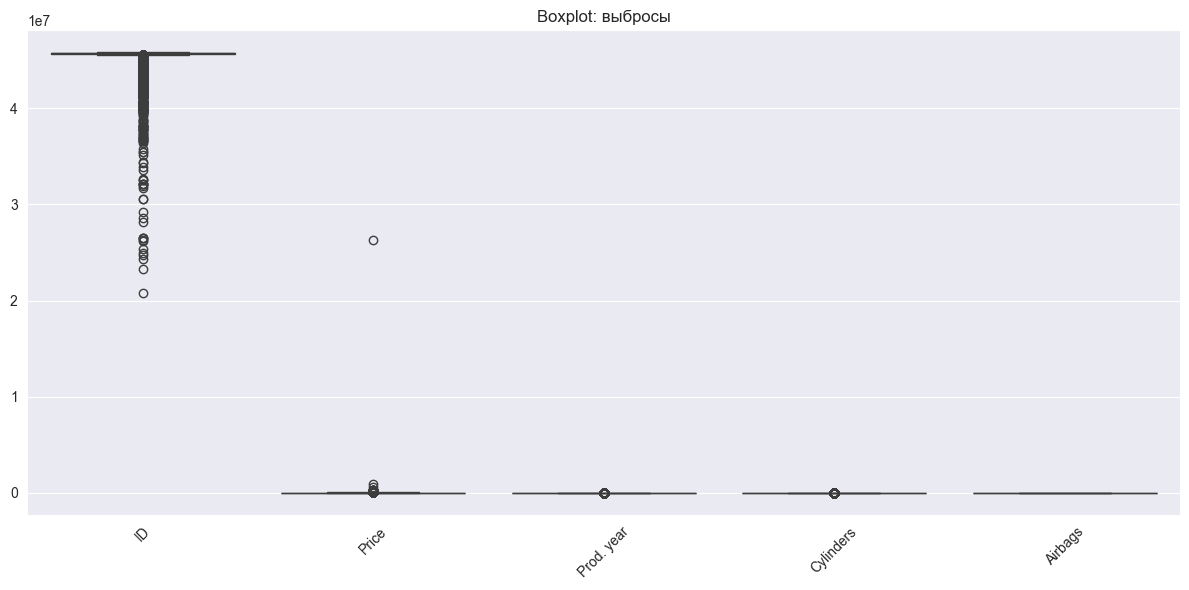

{'shape': (19237, 18), 'noise': {'duplicates': np.int64(313), 'missing_values': np.int64(0)}, 'outliers': {'isolation_forest': 1924, 'z_score': 466}, 'bias': {}, 'freshness': {}, 'leakage': {}}


In [63]:
print(analyze_dataset(cars_prices))

### Personal Key Indicators of Heart Disease

                      АНАЛИЗ ДАТАСЕТА                       
Размер: (246022, 40)
Дубликаты: 9
Пропуски: 0
Выбросы (Isolation Forest): 24603
Выбросы (Z-score > 3): 32621


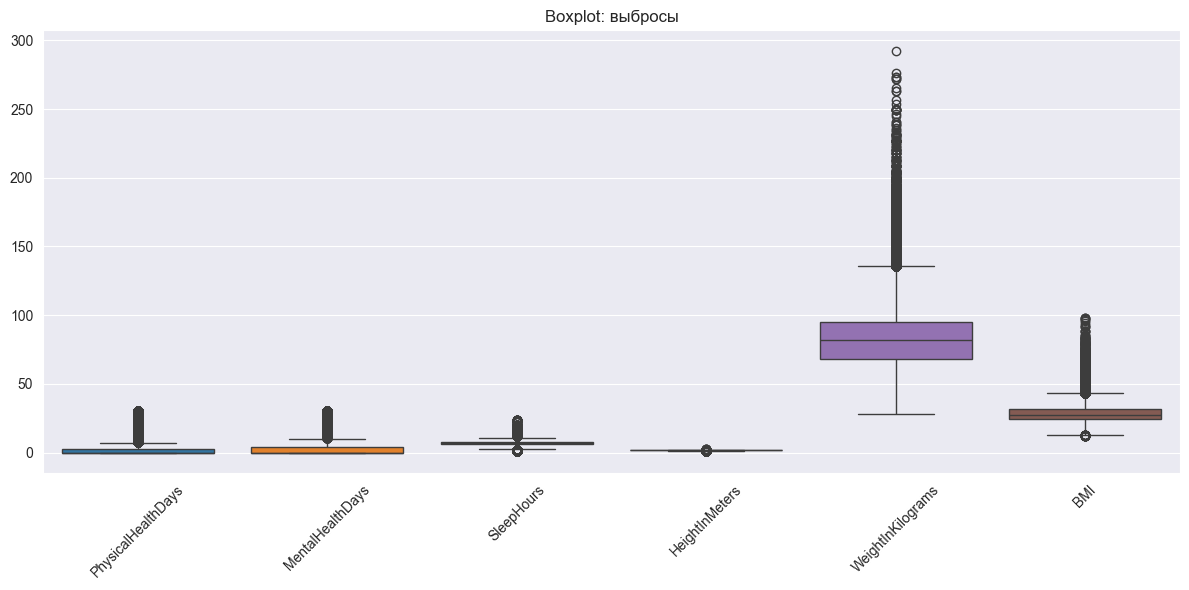

{'shape': (246022, 40), 'noise': {'duplicates': np.int64(9), 'missing_values': np.int64(0)}, 'outliers': {'isolation_forest': 24603, 'z_score': 32621}, 'bias': {}, 'freshness': {}, 'leakage': {}}


In [64]:
print(analyze_dataset(heart_disease_indicators))

## 7. Решение обнаруженных проблем

In [65]:
def clean_dataset(df):
    cleaned_df = df.copy()
    cleaned_df = cleaned_df.drop_duplicates()
    num_cols = cleaned_df.select_dtypes(include=np.number).columns
    for col in num_cols:
        cleaned_df[col] = winsorize(cleaned_df[col], limits=[0.01, 0.01])
    return cleaned_df

### House Sales Prediction

                      АНАЛИЗ ДАТАСЕТА                       
Размер: (18924, 18)
Дубликаты: 1
Пропуски: 0
Выбросы (Isolation Forest): 1893
Выбросы (Z-score > 3): 2051


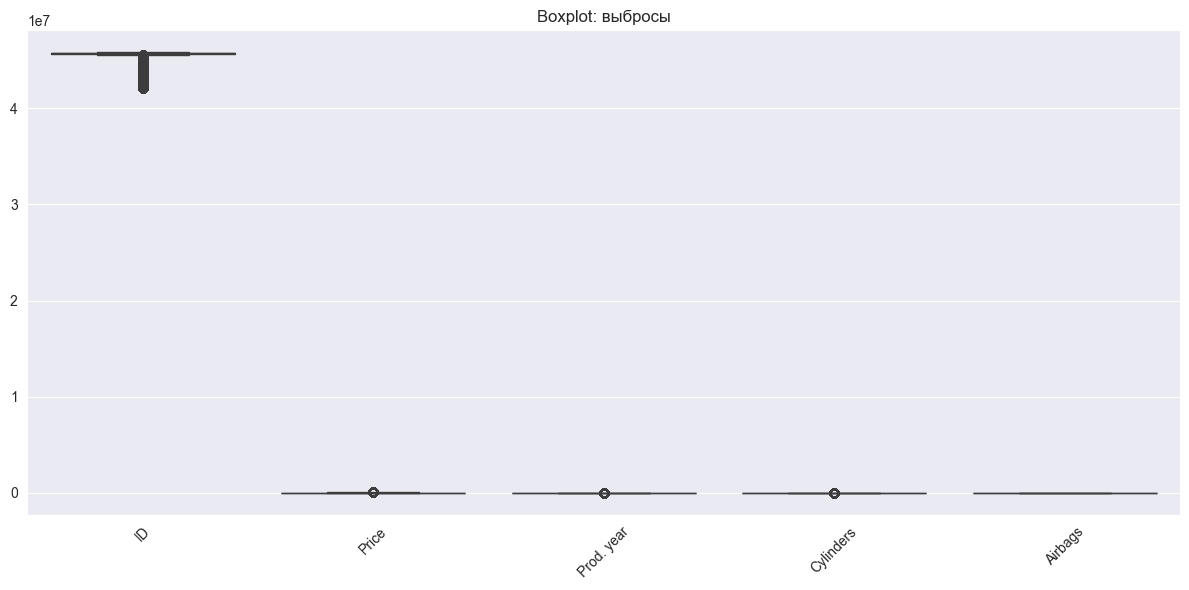

{'shape': (18924, 18), 'noise': {'duplicates': np.int64(1), 'missing_values': np.int64(0)}, 'outliers': {'isolation_forest': 1893, 'z_score': 2051}, 'bias': {}, 'freshness': {}, 'leakage': {}}


In [66]:
cars_prices_cleaned = clean_dataset(cars_prices)
print(analyze_dataset(cars_prices_cleaned))

### Car Price Prediction Challenge

In [67]:
houses_prices_cleaned = clean_dataset(houses_prices)
print(analyze_dataset(houses_prices_cleaned))

                      АНАЛИЗ ДАТАСЕТА                       
Размер: (21613, 21)
Дубликаты: 0
Пропуски: 0
Выбросы (Isolation Forest): 2162
Выбросы (Z-score > 3): 3208
{'shape': (21613, 21), 'noise': {'duplicates': np.int64(0), 'missing_values': np.int64(0)}, 'outliers': {'isolation_forest': 2162, 'z_score': 3208}, 'bias': {}, 'freshness': {}, 'leakage': {}}


### Personal Key Indicators of Heart Disease

                      АНАЛИЗ ДАТАСЕТА                       
Размер: (246013, 40)
Дубликаты: 0
Пропуски: 0
Выбросы (Isolation Forest): 24602
Выбросы (Z-score > 3): 34078


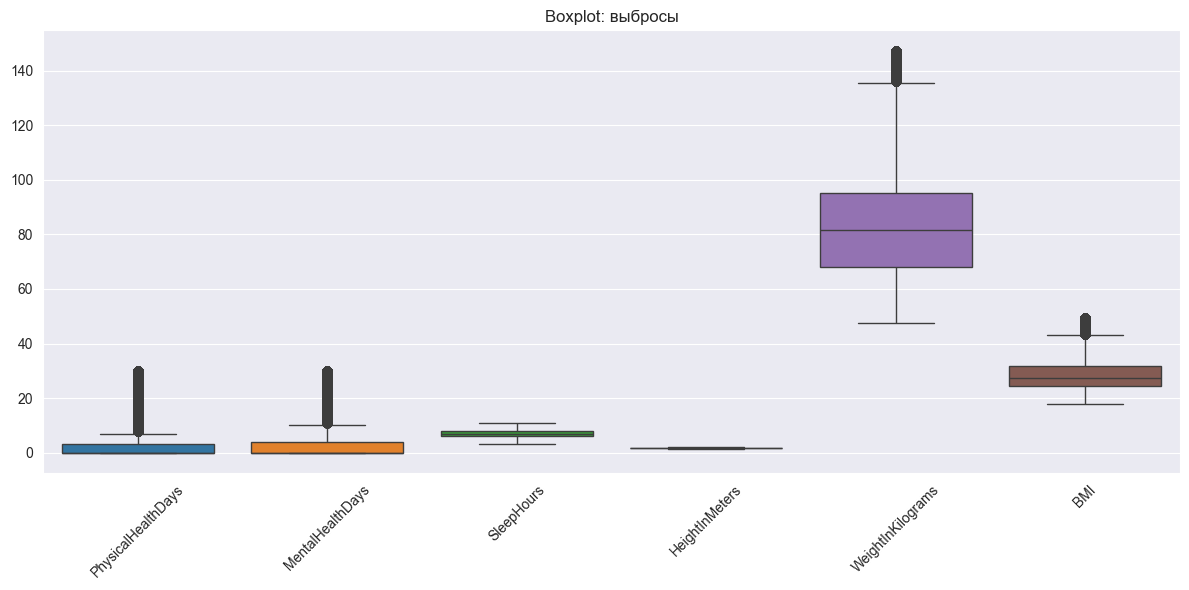

{'shape': (246013, 40), 'noise': {'duplicates': np.int64(0), 'missing_values': np.int64(0)}, 'outliers': {'isolation_forest': 24602, 'z_score': 34078}, 'bias': {}, 'freshness': {}, 'leakage': {}}


In [68]:
heart_disease_indicators_cleaned = clean_dataset(heart_disease_indicators)
print(analyze_dataset(heart_disease_indicators_cleaned))

## 8. Оценка качества наборов данных

### House Sales Prediction

- Информативность: Высокая (21 релевантный признак, корреляция с целевой переменной `price` около 0.7 для `sqft`)
- Степень покрытия: Полная (21 тысяча строк, менее 1% пропущенных значений)
- Соответствие реальным данным: Высокое (основан на реальных данных о продажах недвижимости в округе Кинг Каунти)
- Согласованность меток: Высокая (цена указана последовательно и консистентно)

### Car Price Prediction
- Информативность: Средняя (некоторые признаки, например, `Cylinders`, встречаются редко)
- Степень покрытия: Хорошая (7.5 тысяч строк, но около 20% значений в признаке `Levy` отмечены как '-')
- Соответствие реальным данным: Среднее (возможно, содержит синтетические элементы или является глобальной сборной выборкой)
- Согласованность меток: Средняя (цена указана в долларах США, но возможны вопросы к единообразию)

### Heart Disease Indicators
- Информативность: Высокая (около 40 признаков, включая сильные предикторы, такие как BMI и курение)
- Степень покрытия: Отличная (319 тысяч строк, данные опросов с минимальным количеством пропусков)
- Соответствие реальным данным: Высокое (данные от CDC BRFSS, основаны на валидированных опросах)
- Согласованность меток: Высокая (бинарные метки, такие как "Yes"/"No", стандартизированы)

## 9. Разбиение данных на обучающую, контрольную и тестовую выборки

### House Sales Prediction

In [69]:
X_houses = houses_prices.drop(['price', 'date', 'id'], axis=1)
y_houses = houses_prices['price']
X_train_h, X_temp_h, y_train_h, y_temp_h = train_test_split(X_houses, y_houses, test_size=0.3, random_state=42)
X_val_h, X_test_h, y_val_h, y_test_h = train_test_split(X_temp_h, y_temp_h, test_size=0.5, random_state=42)
print("Houses: Train", X_train_h.shape, "Val", X_val_h.shape, "Test", X_test_h.shape)

Houses: Train (15129, 18) Val (3242, 18) Test (3242, 18)


### Car Price Prediction Challenge

In [70]:
X_cars = cars_prices.drop(['Price', 'ID'], axis=1)
y_cars = cars_prices['Price']
X_train_c, X_temp_c, y_train_c, y_temp_c = train_test_split(X_cars, y_cars, test_size=0.3, random_state=42)
X_val_c, X_test_c, y_val_c, y_test_c = train_test_split(X_temp_c, y_temp_c, test_size=0.5, random_state=42)
print("Cars: Train", X_train_c.shape, "Val", X_val_c.shape, "Test", X_test_c.shape)

Cars: Train (13465, 16) Val (2886, 16) Test (2886, 16)


### Personal Key Indicators of Heart Disease

In [71]:
X_heart = heart_disease_indicators.drop('HadHeartAttack', axis=1)
y_heart = heart_disease_indicators['HadHeartAttack'].map({'Yes': 1, 'No': 0})
X_train_he, X_temp_he, y_train_he, y_temp_he = train_test_split(X_heart, y_heart, test_size=0.3, random_state=42,
                                                                stratify=y_heart)
X_val_he, X_test_he, y_val_he, y_test_he = train_test_split(X_temp_he, y_temp_he, test_size=0.5, random_state=42,
                                                            stratify=y_temp_he)
print("Heart: Train", X_train_he.shape, "Val", X_val_he.shape, "Test", X_test_he.shape)

Heart: Train (172215, 39) Val (36903, 39) Test (36904, 39)


## 10. Устранение пропущенных данных

### House Sales Prediction

In [72]:
print("Houses missing:\n", houses_prices.isnull().sum())
df_houses_clean = houses_prices.dropna()

Houses missing:
 id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


### Car Price Prediction Challenge

In [73]:
print("Cars missing:\n", cars_prices.isnull().sum())
cars_prices['Levy'] = cars_prices['Levy'].replace('-', 0).astype(float)
df_cars_clean = cars_prices.fillna({'Levy': 0})

Cars missing:
 ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


### Personal Key Indicators of Heart Disease

In [74]:
print("Heart missing:\n", heart_disease_indicators.isnull().sum())
heart_disease_indicators['PhysicalHealthDays'] = heart_disease_indicators['PhysicalHealthDays'].fillna(
    heart_disease_indicators['PhysicalHealthDays'].mean())
df_heart_clean = heart_disease_indicators.fillna(
    {'PhysicalHealthDays': heart_disease_indicators['PhysicalHealthDays'].mean()})

Heart missing:
 State                        0
Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms      

## 11. Оценка сбалансированности выборок

### House Sales Prediction

In [75]:
print("Houses price distribution:\n", y_houses.describe())

Houses price distribution:
 count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64


### Car Price Prediction Challenge

In [76]:
print("Cars price distribution:\n", y_cars.describe())

Cars price distribution:
 count    1.923700e+04
mean     1.855593e+04
std      1.905813e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.207500e+04
max      2.630750e+07
Name: Price, dtype: float64


### Personal Key Indicators of Heart Disease

Heart class balance:
 HadHeartAttack
0    0.945391
1    0.054609
Name: proportion, dtype: float64


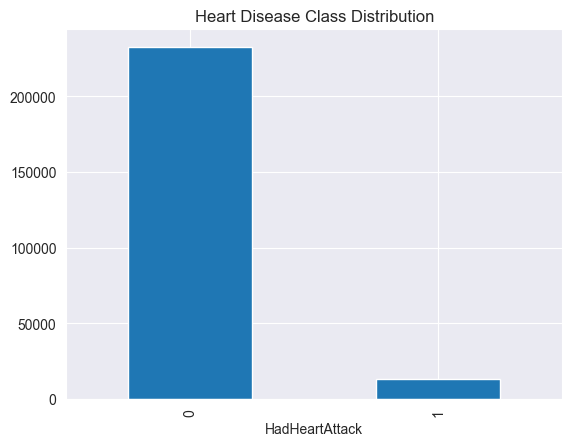

In [77]:
print("Heart class balance:\n", y_heart.value_counts(normalize=True))

y_heart.value_counts().plot(kind='bar')
plt.title('Heart Disease Class Distribution')
plt.show()

## 12. Применение методов сэмплирования для балансировки данных

### House Sales Prediction

In [78]:
median_price = houses_prices['price'].median()
houses_prices['expensive'] = (houses_prices['price'] > median_price).astype(int)

X_house = houses_prices.drop(['id', 'date', 'price', 'expensive'], axis=1, errors='ignore')
y_house = houses_prices['expensive']

print(f"Исходное распределение: {dict(y_house.value_counts())}")

# --- Oversampling ---
print("\n[Oversampling] RandomOverSampler + SMOTE")
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_house, y_house)
print(f"RandomOverSampler: {dict(pd.Series(y_ros).value_counts())}")

smote = SMOTE(random_state=42, k_neighbors=min(2, len(y_house[y_house == 1]) - 1))
X_smote, y_smote = smote.fit_resample(X_house, y_house)
print(f"SMOTE: {dict(pd.Series(y_smote).value_counts())}")
print("Пример новой строки (SMOTE):")
print(pd.concat([X_smote, y_smote], axis=1).iloc[-1:].drop('expensive', axis=1, errors='ignore'))

# --- Undersampling ---
print("\n[Undersampling] RandomUnderSampler")
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_house, y_house)
print(f"RandomUnderSampler: {dict(pd.Series(y_rus).value_counts())}")
print("Пример оставшихся строк:")
print(pd.concat([X_rus, y_rus], axis=1).head(2))

Исходное распределение: {0: np.int64(10864), 1: np.int64(10749)}

[Oversampling] RandomOverSampler + SMOTE
RandomOverSampler: {0: np.int64(10864), 1: np.int64(10864)}
SMOTE: {0: np.int64(10864), 1: np.int64(10864)}
Пример новой строки (SMOTE):
       bedrooms  bathrooms  sqft_living  sqft_lot    floors  waterfront  view  \
21727         6   4.984815         6033    230642  1.997469           0     2   

       condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
21727          3     10        6033              0      2000             0   

       zipcode        lat        long  sqft_living15  sqft_lot15  
21727    98023  47.603869 -121.943116           4200      233944  

[Undersampling] RandomUnderSampler
RandomUnderSampler: {0: np.int64(10749), 1: np.int64(10749)}
Пример оставшихся строк:
       bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
5291          3       1.75         2120     18335     1.0           0     0   
14810         3       

### Car Price Prediction Challenge

In [79]:
median_price = cars_prices['Price'].median()
cars_prices['expensive_car'] = (cars_prices['Price'] > median_price).astype(int)

X_car = cars_prices.drop(['ID', 'Price', 'expensive_car'], axis=1, errors='ignore')
y_car = cars_prices['expensive_car']

X_car_encoded = X_car.copy()
for col in X_car_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_car_encoded[col] = le.fit_transform(X_car_encoded[col].astype(str))

print(f"Исходное распределение: {dict(y_car.value_counts())}")

# --- Oversampling ---
print("\n[Oversampling] Random + SMOTE")
X_ros, y_ros = RandomOverSampler(random_state=42).fit_resample(X_car_encoded, y_car)
print(f"RandomOverSampler: {dict(pd.Series(y_ros).value_counts())}")

min_class_size = len(y_car[y_car == 1])
k = min(2, min_class_size - 1) if min_class_size > 1 else 1
X_smote, y_smote = SMOTE(random_state=42, k_neighbors=k).fit_resample(X_car_encoded, y_car)
print(f"SMOTE: {dict(pd.Series(y_smote).value_counts())}")
print("Пример новой строки (SMOTE):")
print(pd.DataFrame(X_smote).iloc[-1:])

# --- Undersampling ---
print("\n[Undersampling] Random")
X_rus, y_rus = RandomUnderSampler(random_state=42).fit_resample(X_car_encoded, y_car)
print(f"RandomUnderSampler: {dict(pd.Series(y_rus).value_counts())}")
print("Пример оставшихся строк:")
print(pd.concat([X_rus.reset_index(drop=True), y_rus.reset_index(drop=True)], axis=1).head(2))

Исходное распределение: {0: np.int64(9731), 1: np.int64(9506)}

[Oversampling] Random + SMOTE
RandomOverSampler: {1: np.int64(9731), 0: np.int64(9731)}
SMOTE: {1: np.int64(9731), 0: np.int64(9731)}
Пример новой строки (SMOTE):
         Levy  Manufacturer  Model  Prod. year  Category  Leather interior  \
19461  1811.0            32    802        2010         4                 1   

       Fuel type  Engine volume  Mileage  Cylinders  Gear box type  \
19461          5             80     4164        8.0              0   

       Drive wheels  Doors  Wheel  Color  Airbags  
19461             0      1      0     12        0  

[Undersampling] Random
RandomUnderSampler: {0: np.int64(9506), 1: np.int64(9506)}
Пример оставшихся строк:
     Levy  Manufacturer  Model  Prod. year  Category  Leather interior  \
0   765.0            23   1334        2015         9                 1   
1  1202.0            23   1334        2017         9                 1   

   Fuel type  Engine volume  Mileage  Cy

### Personal Key Indicators of Heart Disease

In [80]:
heart_disease_indicators['had_covid'] = (heart_disease_indicators['CovidPos'] == 'Yes').astype(int)

X_health = heart_disease_indicators.drop(['CovidPos', 'had_covid'], axis=1)
y_health = heart_disease_indicators['had_covid']

X_health_encoded = X_health.copy()
for col in X_health_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_health_encoded[col] = le.fit_transform(X_health_encoded[col].astype(str))

print(f"Исходное распределение: {dict(y_health.value_counts())}")

# --- Oversampling ---
print("\n[Oversampling] Random + SMOTE")
X_ros, y_ros = RandomOverSampler(random_state=42).fit_resample(X_health_encoded, y_health)
print(f"RandomOverSampler: {dict(pd.Series(y_ros).value_counts())}")

min_class_size = len(y_health[y_health == 1])
k = min(2, min_class_size - 1) if min_class_size > 1 else 1
X_smote, y_smote = SMOTE(random_state=42, k_neighbors=k).fit_resample(X_health_encoded, y_health)
print(f"SMOTE: {dict(pd.Series(y_smote).value_counts())}")
print("Пример новой строки (SMOTE):")
print(pd.DataFrame(X_smote).iloc[-1:])

# --- Undersampling ---
print("\n[Undersampling] Random")
X_rus, y_rus = RandomUnderSampler(random_state=42).fit_resample(X_health_encoded, y_health)
print(f"RandomUnderSampler: {dict(pd.Series(y_rus).value_counts())}")
print("Пример оставшихся строк:")
print(pd.concat([X_rus.reset_index(drop=True), y_rus.reset_index(drop=True)], axis=1).head(2))

Исходное распределение: {0: np.int64(175698), 1: np.int64(70324)}

[Oversampling] Random + SMOTE
RandomOverSampler: {0: np.int64(175698), 1: np.int64(175698)}
SMOTE: {0: np.int64(175698), 1: np.int64(175698)}
Пример новой строки (SMOTE):
        State  Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
351395     49    1              1            0.469737          9.530263   

        LastCheckupTime  PhysicalActivities  SleepHours  RemovedTeeth  \
351395                1                   1    6.234868             3   

        HadHeartAttack  ...  AgeCategory  HeightInMeters  WeightInKilograms  \
351395               0  ...            2             1.8           78.68373   

              BMI  AlcoholDrinkers  HIVTesting  FluVaxLast12  PneumoVaxEver  \
351395  24.195763                1           1             0              0   

        TetanusLast10Tdap  HighRiskLastYear  
351395                  1                 1  

[1 rows x 39 columns]

[Undersampling] Random
RandomU